In [1]:
import pandas as pd
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
import datetime
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
ltsm = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/Unemployment_Final_edit.xlsx')

In [4]:
ltsm.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23 entries, 0 to 22
Data columns (total 77 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Years                      23 non-null     int64  
 1   CA_Civilian_labor_force_0  23 non-null     float64
 2   CA_Civilian_labor_force_1  23 non-null     float64
 3   CA_Employed_0              23 non-null     float64
 4   CA_Employed_1              23 non-null     float64
 5   CA_Unemployed__0           23 non-null     float64
 6   CA_Unemployed_1            23 non-null     float64
 7   CA_Unemployment_rate_0     23 non-null     float64
 8   CA_Unemployment_rate_1     23 non-null     float64
 9   FL_Civilian_labor_force_0  23 non-null     float64
 10  FL_Civilian_labor_force_1  23 non-null     float64
 11  FL_Employed_0              23 non-null     float64
 12  FL_Employed_1              23 non-null     float64
 13  FL_Unemployed__0           23 non-null     float64
 

**LSTM Model



TX Non metro

In [114]:
# Select the target column
target_column = 'TX_Unemployment_rate_0'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ltsm[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3  # Adjusted time steps
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Debugging print statements
print("Train data length:", len(train_data))
print("Test data length:", len(test_data))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check if the test dataset is empty
if len(X_test) == 0:
    print("Test dataset is empty. Adjust the time_steps or data splitting.")
else:
    # Reshape data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=5)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)


Train data length: 16
Test data length: 7
X_train shape: (13, 3)
X_test shape: (4, 3)
Epoch 1/100
3/3 [==============================] - 5s 10ms/step - loss: 0.3269
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2802
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2357
Epoch 4/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1971
Epoch 5/100
3/3 [==============================] - 0s 8ms/step - loss: 0.1591
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1227
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1013
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0892
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0899
Epoch 10/100
3/3 [==============================] - 0s 8ms/step - loss: 0.0940
Epoch 11/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0939
Epoch 12/100
3/3 [==============================] - 0

In [115]:

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.790807950108025
Test RMSE: 1.919393304106465
Train MAE: 0.6708428395170802
Test MAE: 1.7911427543342457


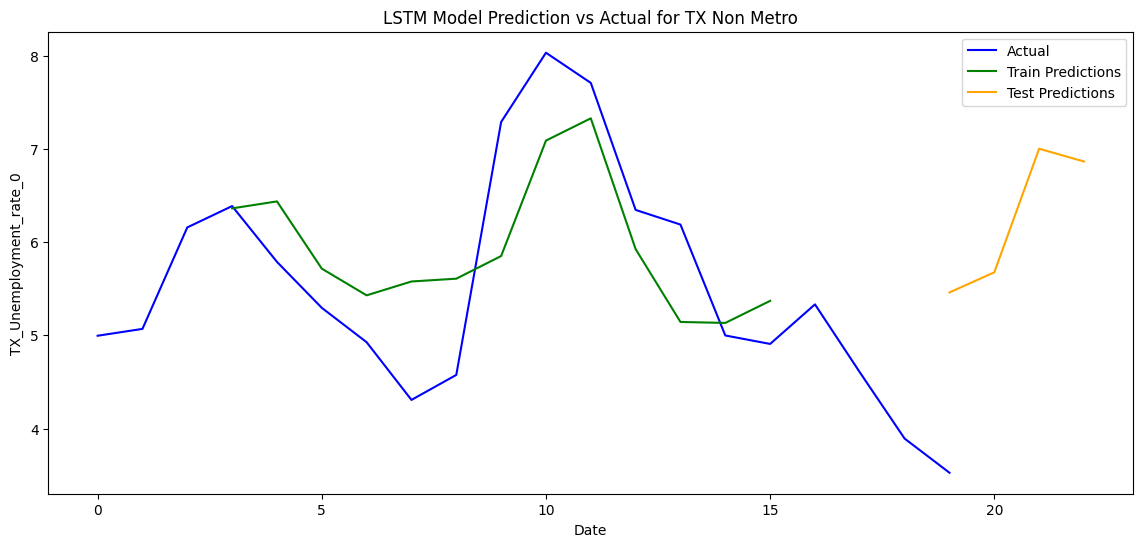

In [116]:
plt.figure(figsize=(14, 6))
plt.plot(ltsm.index[:-time_steps], ltsm[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(ltsm.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(ltsm.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='orange')
plt.title('LSTM Model Prediction vs Actual for TX Non Metro')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()

TX metro

In [111]:
# Select the target column
target_column = 'TX_Unemployment_rate_1'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ltsm[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.8)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3  # Adjusted time steps
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Debugging print statements
print("Train data length:", len(train_data))
print("Test data length:", len(test_data))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check if the test dataset is empty
if len(X_test) == 0:
    print("Test dataset is empty. Adjust the time_steps or data splitting.")
else:
    # Reshape data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=5)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)


Train data length: 18
Test data length: 5
X_train shape: (15, 3)
X_test shape: (2, 3)
Epoch 1/100
3/3 [==============================] - 4s 12ms/step - loss: 0.2880
Epoch 2/100
3/3 [==============================] - 0s 11ms/step - loss: 0.2447
Epoch 3/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2035
Epoch 4/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1695
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1351
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1047
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0914
Epoch 8/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0875
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0886
Epoch 10/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0935
Epoch 11/100
3/3 [==============================] - 0s 11ms/step - loss: 0.0934
Epoch 12/100
3/3 [===========================

In [112]:

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 0.7178378022513738
Test RMSE: 2.375936789649029
Train MAE: 0.5207185782455815
Test MAE: 2.1974038949826866


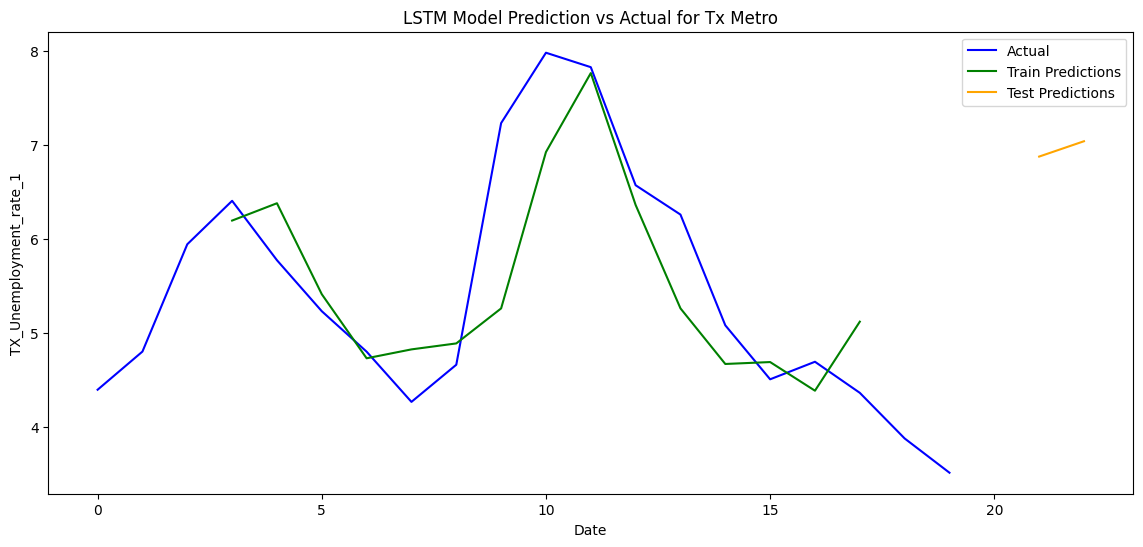

In [113]:
plt.figure(figsize=(14, 6))
plt.plot(ltsm.index[:-time_steps], ltsm[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(ltsm.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(ltsm.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='orange')
plt.title('LSTM Model Prediction vs Actual for Tx Metro')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()

MI non metro

In [104]:
# Select the target column
target_column = 'MI_Unemployment_rate_0'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ltsm[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3  # Adjusted time steps
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Debugging print statements
print("Train data length:", len(train_data))
print("Test data length:", len(test_data))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check if the test dataset is empty
if len(X_test) == 0:
    print("Test dataset is empty. Adjust the time_steps or data splitting.")
else:
    # Reshape data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=5)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)


Train data length: 16
Test data length: 7
X_train shape: (13, 3)
X_test shape: (4, 3)
Epoch 1/100
3/3 [==============================] - 4s 9ms/step - loss: 0.3031
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2680
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2350
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1984
Epoch 5/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1668
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1307
Epoch 7/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0970
Epoch 8/100
3/3 [==============================] - 0s 15ms/step - loss: 0.0718
Epoch 9/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0550
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0555
Epoch 11/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0573
Epoch 12/100
3/3 [==============================] - 

In [105]:

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 1.9258074362736206
Test RMSE: 2.6683605261206074
Train MAE: 1.393724705622747
Test MAE: 2.575530848009833


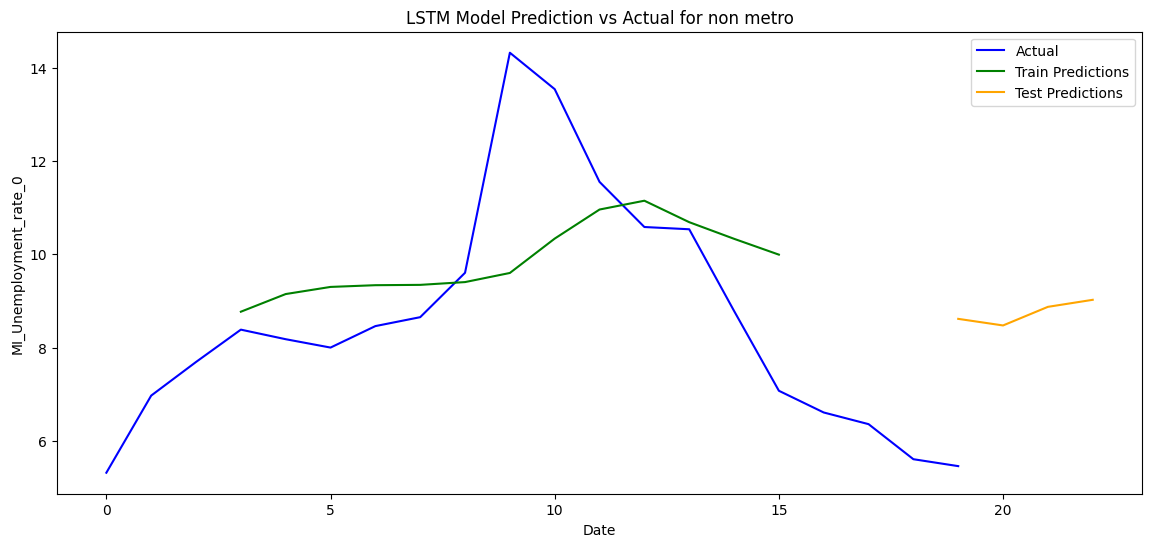

In [106]:
plt.figure(figsize=(14, 6))
plt.plot(ltsm.index[:-time_steps], ltsm[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(ltsm.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(ltsm.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='orange')
plt.title('LSTM Model Prediction vs Actual for non metro')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()

MI metro

In [118]:
# Select the target column
target_column = 'MI_Unemployment_rate_1'

# Normalize the data
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(ltsm[[target_column]])

# Split data into training and testing sets
train_size = int(len(scaled_data) * 0.7)
train_data, test_data = scaled_data[:train_size], scaled_data[train_size:]

# Prepare the data for LSTM
def create_dataset(data, time_steps=1):
    X, y = [], []
    for i in range(len(data) - time_steps):
        X.append(data[i:(i + time_steps), 0])
        y.append(data[i + time_steps, 0])
    return np.array(X), np.array(y)

time_steps = 3  # Adjusted time steps
X_train, y_train = create_dataset(train_data, time_steps)
X_test, y_test = create_dataset(test_data, time_steps)

# Debugging print statements
print("Train data length:", len(train_data))
print("Test data length:", len(test_data))
print("X_train shape:", X_train.shape)
print("X_test shape:", X_test.shape)

# Check if the test dataset is empty
if len(X_test) == 0:
    print("Test dataset is empty. Adjust the time_steps or data splitting.")
else:
    # Reshape data for LSTM
    X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
    X_test = np.reshape(X_test, (X_test.shape[0], X_train.shape[1], 1))

    # Define the LSTM model
    model = Sequential()
    model.add(LSTM(units=50, return_sequences=True, input_shape=(X_train.shape[1], 1)))
    model.add(LSTM(units=50))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')

    # Train the model
    model.fit(X_train, y_train, epochs=100, batch_size=5)

    # Make predictions
    train_predictions = model.predict(X_train)
    test_predictions = model.predict(X_test)


Train data length: 16
Test data length: 7
X_train shape: (13, 3)
X_test shape: (4, 3)
Epoch 1/100
3/3 [==============================] - 4s 9ms/step - loss: 0.2872
Epoch 2/100
3/3 [==============================] - 0s 9ms/step - loss: 0.2436
Epoch 3/100
3/3 [==============================] - 0s 8ms/step - loss: 0.2004
Epoch 4/100
3/3 [==============================] - 0s 9ms/step - loss: 0.1613
Epoch 5/100
3/3 [==============================] - 0s 10ms/step - loss: 0.1198
Epoch 6/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0884
Epoch 7/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0647
Epoch 8/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0562
Epoch 9/100
3/3 [==============================] - 0s 10ms/step - loss: 0.0595
Epoch 10/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0613
Epoch 11/100
3/3 [==============================] - 0s 9ms/step - loss: 0.0585
Epoch 12/100
3/3 [==============================] - 

In [119]:

# Inverse transform the predictions
train_predictions = scaler.inverse_transform(train_predictions.reshape(-1, 1))
test_predictions = scaler.inverse_transform(test_predictions.reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))

# Calculate accuracy metrics
train_rmse = np.sqrt(mean_squared_error(y_train, train_predictions))
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))
train_mae = mean_absolute_error(y_train, train_predictions)
test_mae = mean_absolute_error(y_test, test_predictions)

print("Train RMSE:", train_rmse)
print("Test RMSE:", test_rmse)
print("Train MAE:", train_mae)
print("Test MAE:", test_mae)

Train RMSE: 1.87169960324642
Test RMSE: 2.6090108241468415
Train MAE: 1.302544040228488
Test MAE: 2.545973005661597


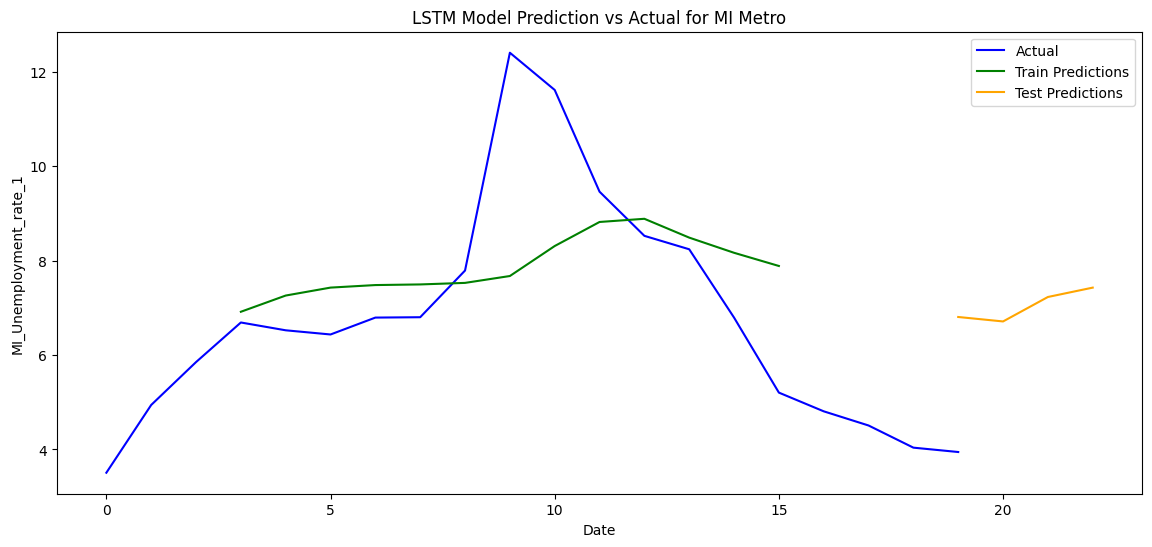

In [120]:
plt.figure(figsize=(14, 6))
plt.plot(ltsm.index[:-time_steps], ltsm[target_column].values[:-time_steps], label='Actual', color='blue')
plt.plot(ltsm.index[time_steps:train_size], train_predictions, label='Train Predictions', color='green')
plt.plot(ltsm.index[train_size + time_steps:], test_predictions, label='Test Predictions', color='orange')
plt.title('LSTM Model Prediction vs Actual for MI Metro')
plt.xlabel('Date')
plt.ylabel(target_column)
plt.legend()
plt.show()